# Objectives

We are using the UCI Heart Disease Data after wrangling in the file data/heart.csv

We will try to predict the indication of heart disease in the target variable.

In this notebook we will do predictive modeling using the pre-processed data files from the Feature Engineering notebook.

We will build models using 5 algorithms: Logistic Regression, Decision Tree, Random Forest, k Nearest Neighbor, and SVM.


# 1. Load the data from the X and y train and test files.

In [2]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.svm          import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, confusion_matrix, classification_report, plot_roc_curve, roc_auc_score

import seaborn as sns
import math

In [3]:
X_train = pd.read_csv('../data/X_train.csv')
Xs_train = pd.read_csv('../data/Xs_train.csv')
X_test  = pd.read_csv('../data/X_test.csv')
Xs_test  = pd.read_csv('../data/Xs_test.csv')

y_train = pd.read_csv('../data/y_train.csv')
y_test  = pd.read_csv('../data/y_test.csv')

pd.options.display.float_format = '{:.4f}'.format
print(X_train.mean(), '\n', X_test.mean())

Age           54.2149
Sex            0.6736
ChestPain      2.7934
SystolicBP   130.9504
Chol         246.0000
Glucose        0.1529
RestECG        0.4876
STMaxRate    151.0661
STPain         0.2934
STWave         0.9752
NumColor       0.6281
STSlope_1      0.4628
STSlope_2      0.4711
Defects_1      0.0496
Defects_2      0.5744
Defects_3      0.3678
dtype: float64 
 Age           54.9672
Sex            0.7213
ChestPain      3.0984
SystolicBP   134.2951
Chol         247.3115
Glucose        0.1311
RestECG        0.5574
STMaxRate    144.0164
STPain         0.4590
STWave         1.1475
NumColor       0.8033
STSlope_1      0.4590
STSlope_2      0.4590
Defects_1      0.0984
Defects_2      0.4426
Defects_3      0.4590
dtype: float64


In [4]:
## Make y's into Series, not DataFrames, to silence model warnings.
y_train = y_train['AngioTgt']
y_test  = y_test['AngioTgt']

### Data check

The means of our train and test sets are not exactly identical, which is fine since the test set is meant to show how the model responds to new data.  The test set has a higher proportion of males, subjects with ChestPain, higher SystolicBP, RestECG, STPain, STWave, NumColor and Defects values 1 and 3.  The test set subjects have a lower average STMaxRate and Defects value 2.  

In [5]:
print(Xs_train.mean(), '\n', Xs_test.mean())

Age_SS           0.0000
Sex              0.6736
ChestPain        2.7934
SystolicBP_SS    0.0000
Chol_SS         -0.0000
Glucose          0.1529
RestECG          0.4876
STMaxRate_SS    -0.0000
STPain           0.2934
STWave           0.9752
NumColor         0.6281
STSlope_1        0.4628
STSlope_2        0.4711
Defects_1        0.0496
Defects_2        0.5744
Defects_3        0.3678
dtype: float64 
 Age_SS           0.0850
Sex              0.7213
ChestPain        3.0984
SystolicBP_SS    0.1921
Chol_SS          0.0252
Glucose          0.1311
RestECG          0.5574
STMaxRate_SS    -0.3239
STPain           0.4590
STWave           1.1475
NumColor         0.8033
STSlope_1        0.4590
STSlope_2        0.4590
Defects_1        0.0984
Defects_2        0.4426
Defects_3        0.4590
dtype: float64


### Scaled data check

Our standardized scaling looks good.  All four features (Age, SystolicBP, Chol and STMaxRate) have 0 means as they should.  Our unscaled numbers match, as they should.

### Reusable python code

In [6]:
def plot_confusion(title, model, x, y, score):
    
    predictions = model.predict(x)
    cm = confusion_matrix(y, predictions)

    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = title + '\nAccuracy Score: {0}%\nRsquared = {1}'\
        .format(round(100*score, 1), round(r2_score(y, predictions),3))
    plt.title(all_sample_title, size = 15);
    print(classification_report(y, predictions))
    plot_roc_curve(model, x, y);
    

class Attribution():
    df = pd.DataFrame()
    
    def __init__ (self, model, features, coeffs, mod=None):
        self.model_name = model
        self.list = zip(features, coeffs)
        if not mod:
            mod = model
        rows=[model, mod + "_rank"]
        newrows = pd.DataFrame(index=rows)
        i=1
        for (f, c) in iter(sorted(self.list, key= lambda y : abs(y[1]), reverse=True)):
            newrows[f] = ('{:.2f}'.format(np.round(c, 2)), int(i))
            i += 1
        Attribution.df.drop(index=rows, errors='ignore', inplace=True)
        Attribution.df = pd.concat([Attribution.df, newrows])

    def report (self, rows=None):
        if rows:
            return Attribution.df.loc[rows].transpose()
        return Attribution.df.transpose()
    
    def printout (self):
        print("\n{} Coefficients:".format(self.model_name))
        for f, imp in iter(sorted(self.list, key= lambda y : abs(y[1]), reverse=True)):
            print("{:13s} {:5.2f}".format(f, np.round(imp, 2)))
            
    

# 2. Logistic Regression

We will use the unscaled training and test sets for a Logistic Regression algorithm.

C:\Users\bradd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8512396694214877 0.8688524590163934
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        32
           1       0.92      0.79      0.85        29

    accuracy                           0.87        61
   macro avg       0.88      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



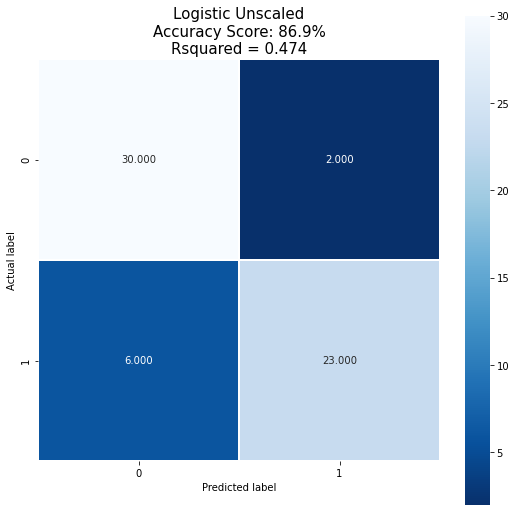

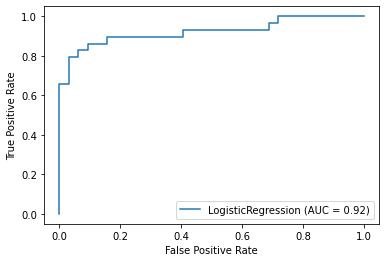

In [7]:
LogReg = LogisticRegression(max_iter=1000)

LogReg.fit(X_train, y_train)

train_score = LogReg.score(X_train, y_train)
score = LogReg.score(X_test, y_test)

print (train_score, score)
plot_confusion("Logistic Unscaled", LogReg, X_test, y_test, score)

att = Attribution('LogReg', X_test.columns, LogReg.coef_[0], 'LR')


0.8471074380165289 0.8688524590163934
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        32
           1       0.92      0.79      0.85        29

    accuracy                           0.87        61
   macro avg       0.88      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



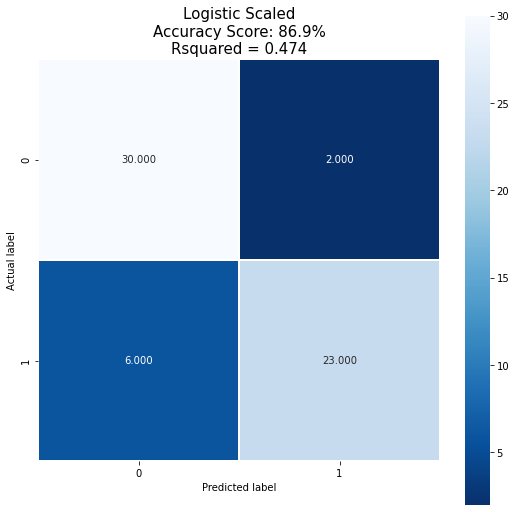

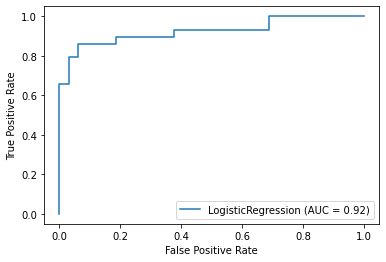

In [8]:
## The algorithm doesn't converge, even after bumping max_iter up from 100 to 1000.  Use the scaled data.
## Despite not converging, the accuracy isn't bad, 86.9%, which is actually HIGHER than the accuracy against the training set.

LogReg.fit(Xs_train, y_train)

train_score = LogReg.score(Xs_train, y_train)
score = LogReg.score(Xs_test, y_test)

print (train_score, score)
plot_confusion("Logistic Scaled", LogReg, Xs_test, y_test, score)
att = Attribution('LogRegScaled', Xs_test.columns, LogReg.coef_[0], 'LRs')


### Logistic Regression Scores

The algorithm converged using the scaled data.  The (test set) accuracy is exactly the same as reported by the uncoverged algorithm against the unscaled data:  86.9%.   The training set accuracy went down slightly from 85.1% to 84.7%.  

Results: 86.9% accuracy, .474 R^2, 92% precision, 79% recall, (.88, .85) F1 and 92% AUC.

Not a bad start.  Let's compare against other algorithms.




# 3. Decision Tree

Let's try a simple decision tree before running a Random Forest.

1.0 0.7704918032786885
9 46
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        32
           1       0.83      0.66      0.73        29

    accuracy                           0.77        61
   macro avg       0.78      0.77      0.77        61
weighted avg       0.78      0.77      0.77        61

1.0 0.7704918032786885
9 46
[0.08775877 0.         0.1796221  0.08986978 0.05556997 0.
 0.05231918 0.05376472 0.0137093  0.03462453 0.1306718  0.02853774
 0.00895302 0.         0.25340783 0.01119127]
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        32
           1       0.83      0.66      0.73        29

    accuracy                           0.77        61
   macro avg       0.78      0.77      0.77        61
weighted avg       0.78      0.77      0.77        61



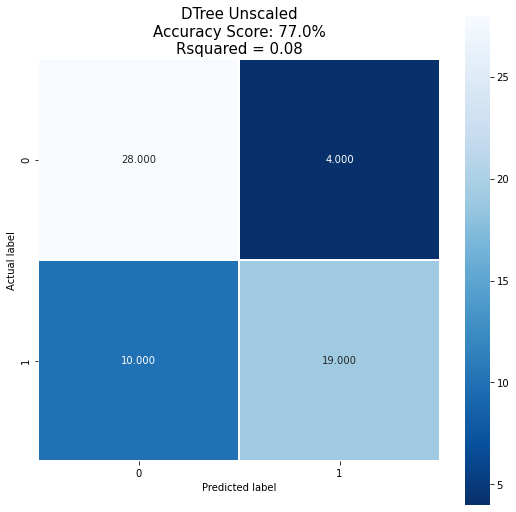

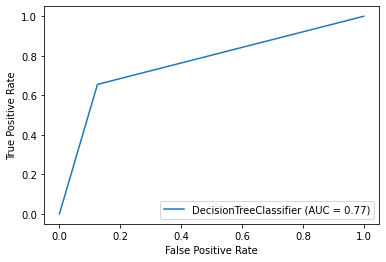

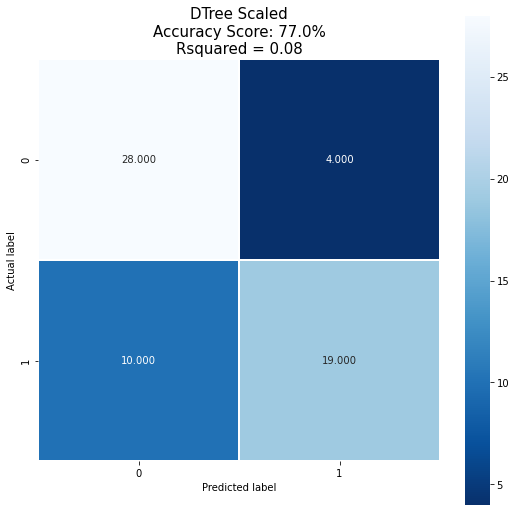

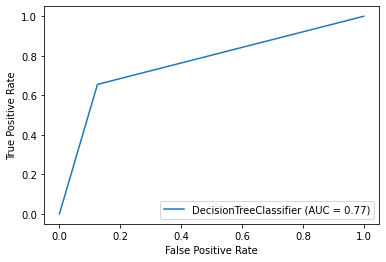

In [9]:
DTree = DecisionTreeClassifier(random_state = 21)
DTree.fit(X_train, y_train)

train_score = DTree.score(X_train, y_train)
score = DTree.score(X_test, y_test)

print (train_score, score)
print(DTree.get_depth(), DTree.get_n_leaves())
plot_confusion("DTree Unscaled", DTree, X_test, y_test, score)
att = Attribution('DTree', X_test.columns, DTree.feature_importances_, 'DT')

## Try the scaled data
DTree.fit(Xs_train, y_train)

train_score = DTree.score(Xs_train, y_train)
score = DTree.score(Xs_test, y_test)

print (train_score, score)
print(DTree.get_depth(), DTree.get_n_leaves())
print(DTree.feature_importances_)
plot_confusion("DTree Scaled", DTree, Xs_test, y_test, score)
att = Attribution('DTreeScaled', Xs_test.columns, DTree.feature_importances_, 'DTs')

### Decision Tree Score

Decision Tree accuracy is identical before and after scaling, as it should be.

DTree: 77% accuracy, .08 R^2, 83% precision, 66% recall, (.80, .73) F1 and 77% AUC.

This model has lousy recall.  It only identified 2/3rds of the actual positive cases.


### Logistic Regression and Decision Tree Feature Importance

In [10]:
att.report(['LogReg','LR_rank','DTree','DT_rank'])

,LogReg,LR_rank,DTree,DT_rank
NumColor,-1.19,1,0.13,3
Sex,-1.12,2,0.00,14
STPain,-0.96,3,0.01,11
Defects_2,0.78,4,0.25,1
Defects_3,-0.71,5,0.01,12
STSlope_1,-0.68,6,0.03,10
Glucose,0.56,7,0.00,15
Defects_1,0.53,8,0.00,16
ChestPain,-0.36,9,0.18,2
STSlope_2,0.33,10,0.01,13


A big part of a medical study like this is to find out which factors best predict actual disease or syndrome.  So I'm running feature importances and coefficients for each algorithm to attribute the target to the features.

The Decision Tree paints quite a different picture of feature importance than did Logistic Regression, in the direction of influence and magnitude, as well as in rank.  

Logistic says NumColor is most important at -1.19, followed by Sex at -1.12, STPain at -0.96, Defects value 2 at 0.78, and Defects value 3 at -0.71.  

Decision Tree says Defects value 2 is most important at 0.25, followed by ChestPain at 0.18, NumColor at (POSITIVE) 0.13, and SystolicBP at 0.09.

# 4. Random Forest

Now the Random Forest model.

The Decision Tree went to a depth of 9.  Let's run Random Forest at that depth once with defaults for other parameters before we tune the typical hyperparameters with Cross Validation.

1.0 0.8360655737704918
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 21, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.85      0.79      0.82        29

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



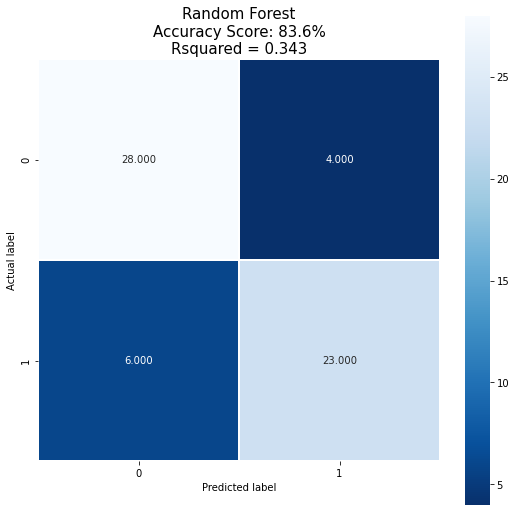

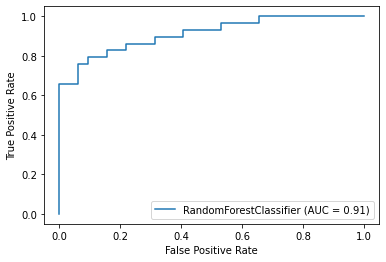

In [11]:
RF = RandomForestClassifier(max_depth=9, random_state = 21)
RF.fit(X_train, y_train)

train_score = RF.score(X_train, y_train)
score = RF.score(X_test, y_test)

print (train_score, score)
print(RF.get_params())

plot_confusion("Random Forest", RF, X_test, y_test, score)
att = Attribution('RF0', X_test.columns, RF.feature_importances_)


Random Forest with max_depth of 9 fared somewhat better than DecisionTree.

* RF shows 83.6% Acc, 0.343 R^2, 85% precision, 79% recall, (.85, .82) F1 and 91% AUC 
* vs. 
* DTree (scaled): 82%, .277 R^2, 82% precision, 79% recall, (.83, .81) F1 and 82% AUC

Let's try it with cross-validation.

Fitting 3 folds for each of 504 candidates, totalling 1512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1512 out of 1512 | elapsed:  3.9min finished


0.9421487603305785 0.8360655737704918
Best Score:0.8265432098765433
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 75}
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        32
           1       0.83      0.83      0.83        29

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



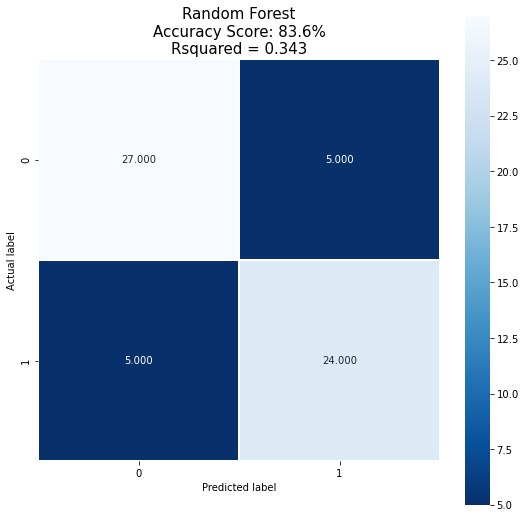

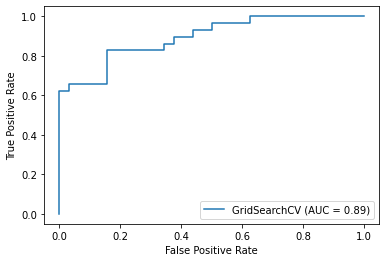

In [12]:
param_grid = {'n_estimators':np.arange(25,176,25), 'criterion':['gini', 'entropy'], 'max_depth':[5,9,10,15],
              'min_samples_split':[2,3,5], 'max_features':[5,10,13]}

rfc = RandomForestClassifier(random_state=21)
rfc_cv= GridSearchCV(rfc, param_grid, cv=3, n_jobs=-1, verbose=3, return_train_score=True)
rfc_cv.fit(X_train, y_train)
train_score = rfc_cv.score(X_train, y_train)
score = rfc_cv.score(X_test, y_test)

print (train_score, score)
print("Best Score:" + str(rfc_cv.best_score_))
print("Best Parameters: " + str(rfc_cv.best_params_))


plot_confusion("Random Forest", rfc_cv, X_test, y_test, score)
att = Attribution('RFcv1', X_test.columns, rfc_cv.best_estimator_.feature_importances_)


* RF D=9 showed 83.6% Acc, .343 R^2, 85% precision, 79% recall, (.85, .82) F1 and 91% AUC
* RF CV1 shows  83.6% Acc, .343 R^w, 83% precision, 83% recall, (.84, .83) F1 and 89% AUC

This grid search produced a Random Forest that improved on the original RF by some measures (recall) and declined in others (precision and AUC).  Let's adjust the parameter grid to bracket this solution and try again.

In [19]:
param_grid2 = {'n_estimators':[60,70,75,80,100,120,130,140,150], 'criterion':['entropy','gini'], 'max_depth':[4,5,9],
               'min_samples_split':[2,3,5],'max_features':[4,5,6]}

rf2 = RandomForestClassifier(random_state=21)
rf2_cv= GridSearchCV(rf2, param_grid2, cv=3, n_jobs=-1, verbose=3, return_train_score=True)
rf2_cv.fit(X_train, y_train)
train_score = rf2_cv.score(X_train, y_train)
score = rf2_cv.score(X_test, y_test)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1458 out of 1458 | elapsed:  3.5min finished


0.9132231404958677 0.8360655737704918
Best Score:0.8430041152263374
Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 130}
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        32
           1       0.83      0.83      0.83        29

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



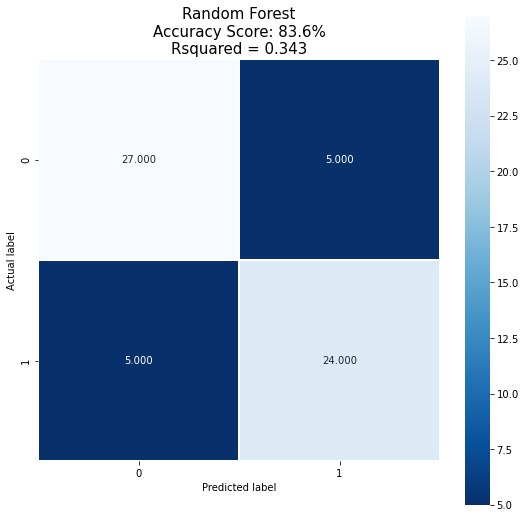

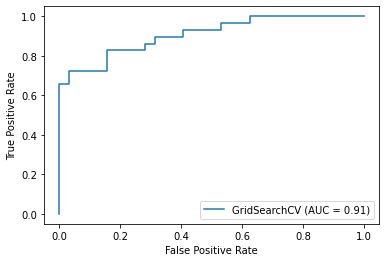

In [18]:
print (train_score, score)
print("Best Score:" + str(rf2_cv.best_score_))
print("Best Parameters: " + str(rf2_cv.best_params_))
att = Attribution('RFcv2', X_test.columns, rf2_cv.best_estimator_.feature_importances_)

plot_confusion("Random Forest", rf2_cv, X_test, y_test, score);

Ok, so we ran this more than once, following n trees as it grew and max features as it shrunk.  The sensitivity to hyper-parameters is quite low.  We've found a number of "best" solutions, depending upon the grid we entered, and most of them have nearly identical fit metrics.

We finally settled on Gini, 130 Trees, Max Depth 4, Min Samples Split 3, Max Features 4 (involved in each split, nominally sqrt(n features) which is about 3.6 for our 13 features).  This edged out the first cross-validation result 91% to 89% in ROC AUC.  Both cv's balanced the precision and recall at 83%.

* RF D=9 shows  83.6% Acc, .343 R^2, 85% precision, 79% recall, (.85, .82) F1 and 91% AUC
* RF CV1 shows  83.6% Acc, .343 R^2, 83% precision, 83% recall, (.84, .83) F1 and 89% AUC
* RF CV2 shows  83.6% acc, .343 R^2, 83% precision, 83% recall, (.84, .83) F1,and 91% AUC

Logistic also beats the Random Forest! 

86.9% vs. 83.6% accuracy, 0.474 vs. 0.343 Rsquared, (.88, .86) to (.84, .83) F1, and 93% to 91% on ROC AUC.

# 5. K Nearest Neighbors

Moving on to K Nearest Neighbors.

9 0.7049180327868853

 Train Accuracy      Test Accuracy
7 0.756198347107438 0.6885245901639344
9 0.7355371900826446 0.7049180327868853
11 0.6900826446280992 0.7049180327868853
13 0.71900826446281 0.6885245901639344
17 0.6983471074380165 0.6885245901639344
19 0.6859504132231405 0.7049180327868853


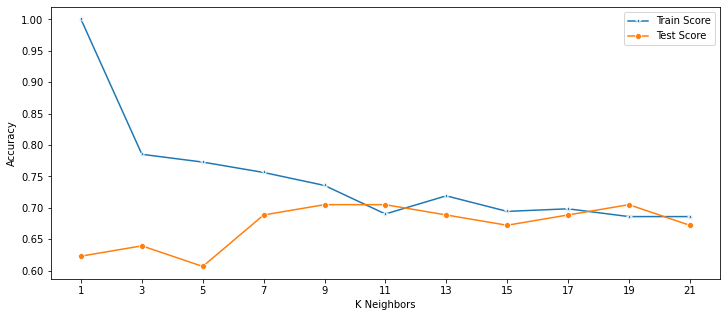

In [8]:
## Start with KNeighborsClassifer with sklearn's defaults and varying n neighbors from 1 to 9, odd numbers only.  
##  Make that 21, as it was still getting better at 9.

## Try it on the unscaled data, for comparison's sake.  The scaled data should be better.
test_scores = []
train_scores = []

for i in range(1,22,2):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))
    
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,22,2), y=train_scores, marker='*',label='Train Score')
p = sns.lineplot(x=range(1,22,2), y=test_scores, marker='o',label='Test Score')
p.set_xlabel('K Neighbors')
p.set_ylabel('Accuracy')
p.set(xticks=range(1,22,2))

maximum = max(test_scores)
print(2*test_scores.index(maximum)+1, maximum)

print('\n','Train Accuracy','     Test Accuracy')
i=0
for t in test_scores:
    if (t > maximum - .02): print(2*i +1, train_scores[i], t, )
    i+=1

As we increase k, the Nearest Neighbors classifier gets less picky and we tend to underfit.  

With unscaled data, the test score crosses the training score at 11 and 19, but on either side of each point the training score beats the test score.  As we increase k past 11, the test score falls off.  We'll take the maximum test score, 70.5% at k=9.

Note, this is considerably worse than Logistic Regression or Random Forest.

Now let's see how Nearest Neighbors does against properly scaled data.

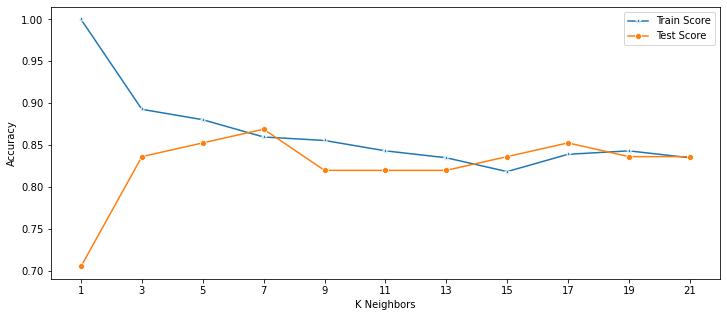

In [10]:
test_scores = []
train_scores = []

for i in range(1,22,2):

    knn = KNeighborsClassifier(i, n_jobs=-1)
    knn.fit(Xs_train,y_train)
    
    train_scores.append(knn.score(Xs_train,y_train))
    test_scores.append(knn.score(Xs_test,y_test))
    
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,22,2), y=train_scores, marker='*',label='Train Score')
p = sns.lineplot(x=range(1,22,2), y=test_scores, marker='o',label='Test Score')
p.set_xlabel('K Neighbors')
p.set_ylabel('Accuracy')
p.set(xticks=range(1,22,2))
plt.show()

In [11]:
maximum = max(test_scores)
best_k = 2*test_scores.index(maximum)+1
print(best_k, maximum)
print('\n','Train Accuracy','     Test Accuracy')
i=0
for t in test_scores:
    if (t > maximum - .02): print(2*i +1, train_scores[i], t, )
    i+=1

7 0.8688524590163934

 Train Accuracy      Test Accuracy
5 0.8801652892561983 0.8524590163934426
7 0.859504132231405 0.8688524590163934
17 0.8388429752066116 0.8524590163934426


Much better, as expected!

The best k moves to 7 and the test score is now 86.9%, matching the Logistic Regression.

Train Score:  0.859504132231405
Test Score:  0.8688524590163934
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.89      0.83      0.86        29

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



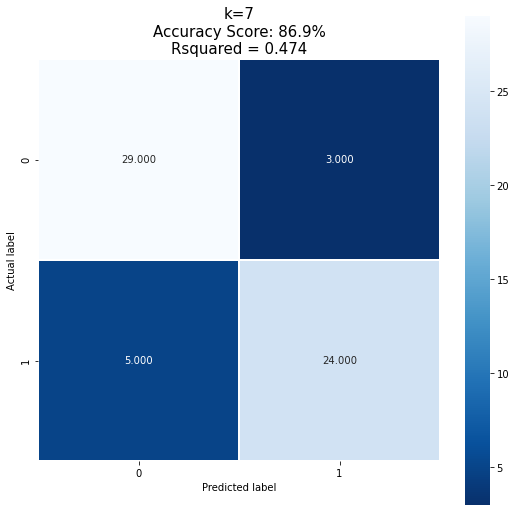

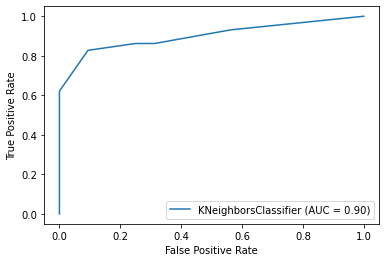

In [40]:
train_score = train_scores[test_scores.index(maximum)]
score = maximum
print("Train Score: ", train_score)
print("Test Score: ", score)
knn = KNeighborsClassifier(best_k, n_jobs=-1)
knn.fit(Xs_train,y_train)

plot_confusion('k=%d' % best_k, knn, Xs_test, y_test, score)

* k=7 shows  86.9% Acc, .474 R^2, 89% precision, 83% recall, (.88, .86) F1 and 90% AUC

This rivals the Logistic Regression performance.
* Logistic:  86.9% accuracy, .474 R^2, 92% precision, 79% recall, (.88, .85) F1 and 92% AUC.

kNN k=7 partially balanced precision and recall and bumped up F1 by 1 point for positive target cases, but it lost 2 points on AUC relative to Logistic.


# 5. Support Vector Machine

The trees lost out to Logistic Regression and kNN.  Let's try an SVM classifier.

0.8842975206611571 0.8688524590163934
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 21, 'shrinking': True, 'tol': 0.001, 'verbose': False}
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.89      0.83      0.86        29

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



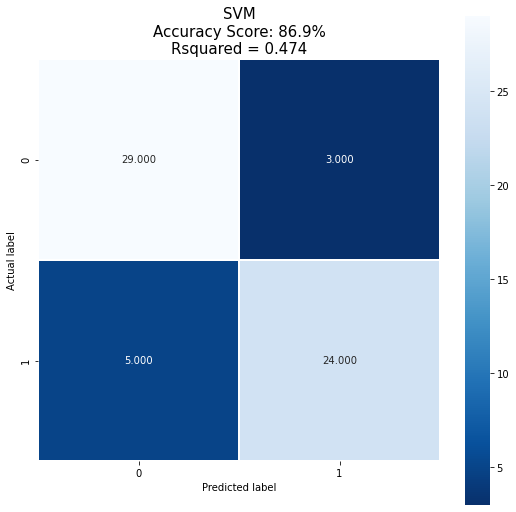

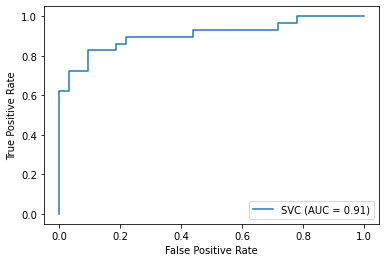

In [42]:
SVM = SVC(random_state = 21)
SVM.fit(Xs_train, y_train)

train_score = SVM.score(Xs_train, y_train)
score = SVM.score(Xs_test, y_test)

print (train_score, score)
print(SVM.get_params())

plot_confusion("SVM", SVM, Xs_test, y_test, score)

We'll run the Linear SVM so that we can get coefficients for the features.  It's performance turns out slightly less than the RBF kernel.

0.8512396694214877 0.819672131147541
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': 21, 'shrinking': True, 'tol': 0.001, 'verbose': False}
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        32
           1       0.82      0.79      0.81        29

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



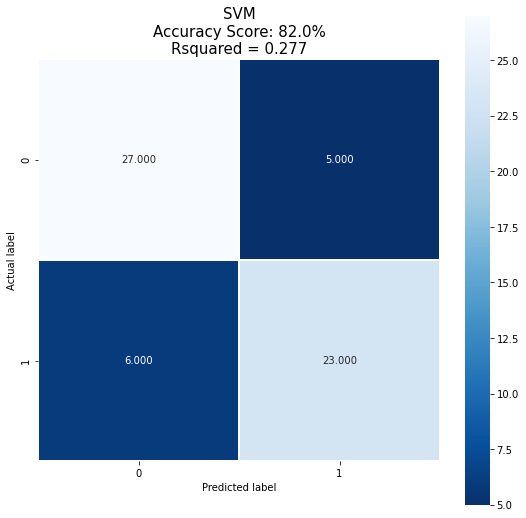

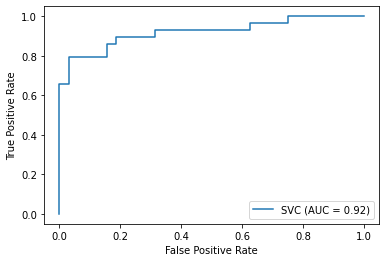

In [43]:
SVM = SVC(kernel='linear',random_state = 21)
SVM.fit(Xs_train, y_train)

train_score = SVM.score(Xs_train, y_train)
score = SVM.score(Xs_test, y_test)

print (train_score, score)
print(SVM.get_params())
att = Attribution('SVM', Xs_test.columns, SVM.coef_[0])

plot_confusion("SVM", SVM, Xs_test, y_test, score)

# 6. Comparison of Model Accuracies

* SVM RBF :  86.9% Acc, .474 R^2, 89% precision, 83% recall, (.88, .86) F1 and 91% AUC
* kNN k=7 :  86.9% Acc, .474 R^2, 89% precision, 83% recall, (.88, .86) F1 and 90% AUC
* RF CV2 : 83.6% acc, .343 R^2, 83% precision, 83% recall, (.84, .83) F1,and 91% AUC
* RF CV1 : 83.6% Acc, .343 R^2, 83% precision, 83% recall, (.84, .83) F1 and 89% AUC
* Logistic :  86.9% accuracy, .474 R^2, 92% precision, 79% recall, (.88, .85) F1 and 92% AUC.
* RF D=9 : 83.6% Acc, .343 R^2, 85% precision, 79% recall, (.85, .82) F1 and 91% AUC
* SVM Linear: 82.0% Acc, .277 R^2, 82% precision, 79% recall, (.83, .81) F1 and 92% AUC
* Dec Tree : 77% accuracy, .08 R^2, 83% precision, 66% recall, (.80, .73) F1 and 77% AUC.

Since this is a medical diagnose study, I ranked these by recall.

The top 4 all tie at 83%, not very good for medical diagnosis.  The next 3 are at 79% and DTree is at 66%.

For tiebreakers, I used F1 for the positive case, AngioTgt=1, and ROC AUC.  The regular SVM (RBF) edges out kNN (k=7) by 1 AUC point.  The cross-validated Random Forests trail by 3 F1 points.

The data are nearly balanced with 32 actual negatives and 29 actual positive targets.  So we could go by R^2 and Accuracy, which show a 3-way tie between SVM RBF, kNN k=7 and Logistic.

SVM RBF is the best model, based on Recall, F1 (1), and being within 1 point on ROC AUC.


# 7. Feature Attribution / Importance

kNN cannot provide any indication of the relative importance of features.  SVM can only if you use the linear kernel.  Here is a look at the feature importances we collected.  I have omitted Decision Tree, because it clearly gave an inferior fit compared to the other models.


In [48]:
att.report(['LogReg','LR_rank','RF0','RF0_rank','RFcv1','RFcv1_rank','RFcv2','RFcv2_rank','SVM','SVM_rank'])

,LogReg,LR_rank,RF0,RF0_rank,RFcv1,RFcv1_rank,RFcv2,RFcv2_rank,SVM,SVM_rank
NumColor,-1.19,1,0.14,1,0.14,1,0.17,1,-0.81,1
Sex,-1.12,2,0.03,13,0.03,11,0.02,13,-0.43,7
STPain,-0.96,3,0.06,10,0.07,7,0.07,6,-0.77,2
Defects_2,0.78,4,0.09,4,0.10,4,0.12,3,0.75,3
Defects_3,-0.71,5,0.08,5,0.10,5,0.11,4,-0.45,6
STSlope_1,-0.68,6,0.03,11,0.02,13,0.04,11,-0.55,5
Glucose,0.56,7,0.01,15,0.01,15,0.00,15,0.38,8
Defects_1,0.53,8,0.00,16,0.00,16,0.00,16,0.69,4
ChestPain,-0.36,9,0.11,2,0.13,2,0.14,2,-0.17,12
STSlope_2,0.33,10,0.03,12,0.03,12,0.04,10,0.22,10


## Relative Importance of Diagnostic Tests

1. All the models except Decision Tree put NumColor as the most important feature.  This would make sense because the target measure of heart disease is the narrowing of the cardiac artery via angiogram and the coloration is another way to measure the narrowing of 4 arteries in the area.  **However, the models don't agree on the direction of its influence!!**

2. Logistic Regression, the only model of the top 3 fits which produces an attribution, puts Sex (M=1) at the 2nd most important, with male subjects less likely to have the target than the female subjects.  The other models show Sex as one of the least important features

3. Logistic counts STPain (during the stress test) as the 3rd most important, the Linear Support Vector Machine puts it at 2nd.  All the tree-based models rank it middling to low.

4. Defects 2 and 3 (Fixed or Reversible Defect) come in 4th and 5th or better in most of the models.

5. Chest Pain (in general, not during the stress test) comes in 2nd in the Random Forest models, but 9th in Logistic and 12th in SVM Linear.

6. None of the other features really stands out.

In short, we cannot make any definitive statements about the relative importance of the diagnostic tests from this dataset.



